# 1. Data Imports and setting environment

**Project:** Predicting ventilator requirements for COVID‑19 (Target: `INTUBATED`)  
**Notebook:** `04_smote_cv_optuna.ipynb` (SMOTE + CV + Optuna tuning)  

> **Goal:** Compare class imbalance strategies and tune an XGBoost classifier using cross‑validation and Optuna. Save trials, best parameters, and final artefacts to `notebooks/outputs/`.


In [16]:
# ---------------------------------------------------------------------
# 1.1 Imports
# ---------------------------------------------------------------------
from __future__ import annotations

from pathlib import Path
import json
import warnings
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [17]:
# ---------------------------------------------------------------------
# 1.2 Reproducibility + paths
# ---------------------------------------------------------------------
SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Choose which dataset variant to tune (produced by 03_feature_engineering.ipynb)
DATASET_VARIANT = "dataset_v2_severity.parquet"
DATA_PATH = OUTPUT_DIR / DATASET_VARIANT

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)


PROJECT_ROOT: /Users/creer/Desktop/covid-ventilator-prediction-xgboost:
DATA_PATH: /Users/creer/Desktop/covid-ventilator-prediction-xgboost:/outputs/dataset_v2_severity.parquet


# 2.0 Load Dataset Variant

This notebook expects dataset variants created in `03_feature_engineering.ipynb`.

- Default: `dataset_v2_severity.parquet`
- You can change `DATASET_VARIANT` at the top of the notebook.


In [18]:
# ---------------------------------------------------------------------
# 2.1 Load data
# ---------------------------------------------------------------------
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Missing dataset at {DATA_PATH}. "
        "Run 03_feature_engineering.ipynb first, or update DATASET_VARIANT."
    )

df = pd.read_parquet(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (192706, 24)


,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,comorbidity_count,severity_score,intubated
0,0,1,0,0,09/06/2020,1,0,55,97,1,2,2,2,2,2,2,2,2,2,3,2,0,0,1
1,0,1,1,0,9999-99-99,0,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2,0,1,0
2,0,1,1,0,9999-99-99,0,0,37,2,1,2,2,2,1,2,2,1,2,2,3,2,0,0,0
3,0,1,1,0,9999-99-99,0,0,25,2,2,2,2,2,2,2,2,2,2,2,3,2,0,0,0
4,0,1,0,0,9999-99-99,0,0,24,97,2,2,2,2,2,2,2,2,2,2,3,2,0,0,0


In [19]:
# ---------------------------------------------------------------------
# 2.2 Split target/features
# ---------------------------------------------------------------------
TARGET = "intubated"
if TARGET not in df.columns:
    raise KeyError(f"Expected target column '{TARGET}' not found. Columns: {list(df.columns)[:30]} ...")

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int).copy()

print("Positive rate:", (y == 1).mean())


Positive rate: 0.174649466025967


# Leakage controls (feature availability at prediction time)

To avoid **target leakage**, we exclude variables that represent downstream clinical outcomes or care pathways
(e.g., ICU admission, death date, inpatient status). This aligns prediction with information plausibly available
at or near presentation.


In [20]:
# ---------------------------------------------------------------------
# Leakage feature removal (downstream outcomes / care-pathway indicators)
# ---------------------------------------------------------------------
LEAKAGE_COLS = ["icu", "date_died", "patient_type"]

to_drop = [c for c in LEAKAGE_COLS if c in X.columns]
if to_drop:
    print("Dropping leakage columns:", to_drop)
    X = X.drop(columns=to_drop)
else:
    print("No leakage columns detected to drop.")

# Sanity checks
print("X shape:", X.shape)
print("Target distribution (proportion):")
display(y.value_counts(normalize=True).rename("proportion"))

# ---------------------------------------------------------------------
# Additional leakage: source-of-target / near-duplicate target columns
# ---------------------------------------------------------------------
SOURCE_OF_TARGET = ["intubed"]  # raw coded column used to create y

to_drop2 = [c for c in SOURCE_OF_TARGET if c in X.columns]
if to_drop2:
    print("Dropping source-of-target columns:", to_drop2)
    X = X.drop(columns=to_drop2)
else:
    print("No source-of-target columns detected.")


Dropping leakage columns: ['icu', 'date_died', 'patient_type']
X shape: (192706, 20)
Target distribution (proportion):


intubated
0    0.825351
1    0.174649
Name: proportion, dtype: float64

Dropping source-of-target columns: ['intubed']


# 3.0 Preprocessing Pipeline

We use a standard preprocessing approach:
- Numeric: median imputation
- Categorical: most frequent imputation + one‑hot encoding (if any)


In [21]:
# ---------------------------------------------------------------------
# 3.1 Column types
# ---------------------------------------------------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 19
Categorical features: 0


In [22]:
# ---------------------------------------------------------------------
# 3.2 Preprocessor
# ---------------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ],
    remainder="drop")


# 4.0 Cross‑Validation Setup

We evaluate using **Stratified K‑Fold** cross‑validation to preserve the class distribution.

**Metrics:**
- F1
- Recall
- Precision

> Note: PR‑AUC can be added later in the final evaluation notebook.


In [23]:
# ---------------------------------------------------------------------
# 4.1 CV + scorers
# ---------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scoring = {
    "f1": make_scorer(f1_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score),
}


# 5.0 Compare Imbalance Strategies (Baseline vs Class Weight vs SMOTE)

We compare three approaches:
1. **Baseline** (no imbalance handling)
2. **Class weighting** (`scale_pos_weight`)
3. **SMOTE** (synthetic minority oversampling) within the CV pipeline

> SMOTE must be applied **inside** cross‑validation folds to avoid data leakage.


In [24]:
# ---------------------------------------------------------------------
# 5.1 Helper: build XGBoost pipeline (with optional SMOTE)
# ---------------------------------------------------------------------
def build_xgb_pipeline(use_smote: bool, scale_pos_weight: float | None = None):
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1.0,
        gamma=0.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    if use_smote:
        try:
            from imblearn.over_sampling import SMOTE
            from imblearn.pipeline import Pipeline as ImbPipeline
        except ImportError as e:
            raise ImportError("This notebook requires imbalanced-learn. Install: pip install imbalanced-learn") from e

        pipe = ImbPipeline(steps=[
            ("preprocess", preprocess),
            ("smote", SMOTE(random_state=SEED)),
            ("model", xgb)
        ])
    else:
        pipe = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", xgb)
        ])

    return pipe


In [25]:
# ---------------------------------------------------------------------
# 5.2 Compute scale_pos_weight for class weighting
# ---------------------------------------------------------------------
pos = (y == 1).sum()
neg = (y == 0).sum()
scale_pos_weight = float(neg / max(pos, 1))
scale_pos_weight


4.7257546945566915

In [26]:
# ---------------------------------------------------------------------
# 5.3 Run CV comparisons
# ---------------------------------------------------------------------
strategies = [
    ("baseline", dict(use_smote=False, spw=None)),
    ("class_weight", dict(use_smote=False, spw=scale_pos_weight)),
    ("smote", dict(use_smote=True, spw=None)),
]

rows = []
for name, cfg in strategies:
    pipe = build_xgb_pipeline(use_smote=cfg["use_smote"], scale_pos_weight=cfg["spw"])
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=False)

    row = {
        "strategy": name,
        "f1_mean": float(np.mean(scores["test_f1"])),
        "f1_std": float(np.std(scores["test_f1"])),
        "recall_mean": float(np.mean(scores["test_recall"])),
        "recall_std": float(np.std(scores["test_recall"])),
        "precision_mean": float(np.mean(scores["test_precision"])),
        "precision_std": float(np.std(scores["test_precision"])),
    }
    rows.append(row)

cv_comparison = pd.DataFrame(rows).sort_values("f1_mean", ascending=False)
cv_comparison


,strategy,f1_mean,f1_std,recall_mean,recall_std,precision_mean,precision_std
1,class_weight,0.381694,0.001560,0.719901,0.004778,0.259693,0.000908
2,smote,0.325203,0.001372,0.362818,0.003085,0.294681,0.002337
0,baseline,0.010823,0.001971,0.005467,0.001005,0.566012,0.075476


In [27]:
# ---------------------------------------------------------------------
# 5.4 Save CV comparison table
# ---------------------------------------------------------------------
cv_comp_path = OUTPUT_DIR / "cv_imbalance_comparison.csv"
cv_comparison.to_csv(cv_comp_path, index=False)
print("Saved:", cv_comp_path.name)


Saved: cv_imbalance_comparison.csv


# 6.0 Optuna Hyperparameter Optimisation (XGBoost)

We tune XGBoost hyperparameters under cross‑validation.

**Optimisation objective:** maximise mean CV F1-score.

**Chosen strategy:** By default we tune the **SMOTE pipeline**, since it often improves recall in imbalanced settings.

> You can change `TUNE_STRATEGY` to tune the baseline or class-weighted pipeline.


In [28]:
# ---------------------------------------------------------------------
# 6.1 Optuna setup
# ---------------------------------------------------------------------
try:
    import optuna
except ImportError as e:
    raise ImportError("This notebook requires optuna. Install: pip install optuna") from e

TUNE_STRATEGY = "smote"  # one of {"baseline", "class_weight", "smote"}
N_TRIALS = 50            # increase if time allows
TIMEOUT = None           # seconds, or None

print("TUNE_STRATEGY:", TUNE_STRATEGY)
print("N_TRIALS:", N_TRIALS)


TUNE_STRATEGY: smote
N_TRIALS: 50


In [29]:
# ---------------------------------------------------------------------
# 6.2 Objective function
# ---------------------------------------------------------------------
def objective(trial: "optuna.trial.Trial") -> float:
    # Hyperparameter search space (sensible, not overly wide)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
    }

    # Determine imbalance strategy
    use_smote = (TUNE_STRATEGY == "smote")
    spw = scale_pos_weight if (TUNE_STRATEGY == "class_weight") else None

    from xgboost import XGBClassifier

    xgb = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=1,
        scale_pos_weight=spw
    )

    if use_smote:
        from imblearn.over_sampling import SMOTE
        from imblearn.pipeline import Pipeline as ImbPipeline
        pipe = ImbPipeline(steps=[
            ("preprocess", preprocess),
            ("smote", SMOTE(random_state=SEED)),
            ("model", xgb)
        ])
    else:
        pipe = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", xgb)
        ])

    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=False)
    return float(np.mean(scores["test_f1"]))


In [30]:
# ---------------------------------------------------------------------
# 6.3 Run Optuna study with tracker
# ---------------------------------------------------------------------
import time
t0 = time.time()
def progress_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial) -> None:
    n_done = len(study.trials)
    best = study.best_value if study.best_trial is not None else None
    elapsed_min = (time.time() - t0) / 60

    print(
        f"[Optuna] Trial {n_done}/{N_TRIALS} | "
        f"value={trial.value:.4f} | best={best:.4f} | "
        f"elapsed={elapsed_min:.1f} min"
    )

study = optuna.create_study(direction="maximize", study_name="xgb_smote_cv_f1")
study.optimize(
    objective,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    callbacks=[progress_callback],
    show_progress_bar=True,)
print("Best value:", study.best_value)
print("Best params:", study.best_params)


[I 2026-01-11 14:24:28,761] A new study created in memory with name: xgb_smote_cv_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-11 14:24:49,981] Trial 0 finished with value: 0.3128728217437301 and parameters: {'n_estimators': 572, 'max_depth': 5, 'learning_rate': 0.08612339759748752, 'subsample': 0.6291461090905676, 'colsample_bytree': 0.6271896609104461, 'min_child_weight': 1.0968511301973112, 'gamma': 1.3678014741759759, 'reg_lambda': 0.12540328247737992}. Best is trial 0 with value: 0.3128728217437301.
[Optuna] Trial 1/50 | value=0.3129 | best=0.3129 | elapsed=0.4 min
[I 2026-01-11 14:25:03,653] Trial 1 finished with value: 0.3184159879834426 and parameters: {'n_estimators': 335, 'max_depth': 6, 'learning_rate': 0.07496289874458482, 'subsample': 0.8071733078187792, 'colsample_bytree': 0.729941940998352, 'min_child_weight': 1.4619518572680978, 'gamma': 2.6645787137294996, 'reg_lambda': 5.275098153265557}. Best is trial 1 with value: 0.3184159879834426.
[Optuna] Trial 2/50 | value=0.3184 | best=0.3184 | elapsed=0.6 min
[I 2026-01-11 14:25:24,986] Trial 2 finished with value: 0.31793357371924674 and 

In [31]:
# ---------------------------------------------------------------------
# 6.4 Save trials + best params
# ---------------------------------------------------------------------
trials_df = study.trials_dataframe()
trials_path = OUTPUT_DIR / "optuna_trials.csv"
trials_df.to_csv(trials_path, index=False)

best_params_path = OUTPUT_DIR / "best_params.json"
with open(best_params_path, "w") as f:
    json.dump(
        {
            "created_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
            "seed": SEED,
            "dataset_variant": DATASET_VARIANT,
            "tune_strategy": TUNE_STRATEGY,
            "best_value_f1": float(study.best_value),
            "best_params": study.best_params,
        },
        f,
        indent=2
    )

print("Saved:", trials_path.name)
print("Saved:", best_params_path.name)


Saved: optuna_trials.csv
Saved: best_params.json


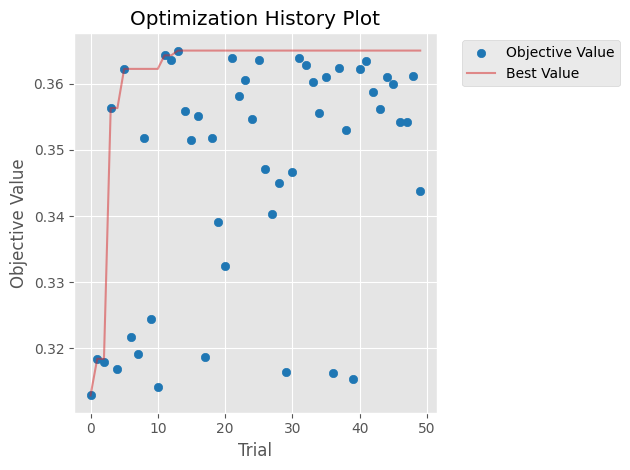

Saved: /Users/creer/Desktop/covid-ventilator-prediction-xgboost:/outputs/figures/optuna_optimization_history.png


In [32]:
# ---------------------------------------------------------------------
# 6.5 Visualise optimisation history
# ---------------------------------------------------------------------
try:
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    fig_path = FIG_DIR / "optuna_optimization_history.png"
    fig.figure.savefig(fig_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", fig_path)
except Exception as e:
    print("Optuna matplotlib visualisation not available:", type(e).__name__)


# 7.0 Train Final Model Using Best Parameters

We train a final pipeline on the full dataset using the best Optuna parameters and save the trained model.

> Final held‑out evaluation and threshold selection are handled in `05_evaluation.ipynb`.


In [33]:
# ---------------------------------------------------------------------
# 7.1 Fit final model on full data
# ---------------------------------------------------------------------
from xgboost import XGBClassifier

best_params = study.best_params

spw = scale_pos_weight if (TUNE_STRATEGY == "class_weight") else None
use_smote = (TUNE_STRATEGY == "smote")

xgb_final = XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=spw
)

if use_smote:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    final_pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=SEED)),
        ("model", xgb_final)
    ])
else:
    final_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", xgb_final)
    ])

final_pipe.fit(X, y)
print("Trained final model with strategy:", TUNE_STRATEGY)


Trained final model with strategy: smote


In [34]:
# ---------------------------------------------------------------------
# 7.2 Save final model artefact
# ---------------------------------------------------------------------
import joblib

final_model_path = OUTPUT_DIR / "final_model.pkl"
joblib.dump(final_pipe, final_model_path)

final_meta_path = OUTPUT_DIR / "final_model_meta.json"
with open(final_meta_path, "w") as f:
    json.dump(
        {
            "created_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
            "seed": SEED,
            "dataset_variant": DATASET_VARIANT,
            "tune_strategy": TUNE_STRATEGY,
            "best_params": best_params,
            "cv_best_value_f1": float(study.best_value),
        },
        f,
        indent=2
    )

print("Saved:", final_model_path.name)
print("Saved:", final_meta_path.name)


Saved: final_model.pkl
Saved: final_model_meta.json


***Summary of Tuning***

- Cross‑validation was used to compare imbalance strategies (baseline vs class weighting vs SMOTE).
- Optuna was used to optimise XGBoost hyperparameters under CV, using mean F1 as the objective.
- The best parameters and full trial history were saved for transparency.
- A final model was trained on the full dataset; final evaluation is completed in `05_evaluation.ipynb`.
